<a href="https://colab.research.google.com/github/ZaimaSartajTaheri/ResearchCodes/blob/main/Z_Inception_RestNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


In [50]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    # rotation_range=20,
     #width_shift_range=0.1,
    # shear_range=0.1,
     zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [51]:
train = image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Train', 
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

validation =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Val', 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='categorical',
                                                target_size=(224, 224))

test =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Test', 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

Found 8376 images belonging to 3 classes.
Found 2792 images belonging to 3 classes.
Found 2790 images belonging to 3 classes.


In [52]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.layers import Dropout
from keras.layers import Input, Flatten, Dense
from keras.models import Model


# Finetuning on another 100-class dataset
base_model = InceptionResNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet', pooling='avg')
outputs = Dense(3, activation='softmax')(base_model.output)
model = Model(base_model.inputs, outputs)


model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])



219062272/219055592 [==============================] - 1s 0us/step


In [53]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [54]:
r = model.fit(
    train, 
    epochs=15,
    validation_data=validation,
    validation_steps=100
)

Epoch 1/15
262/262 [==============================] - 193s 666ms/step - loss: 0.2714 - accuracy: 0.8895 - val_loss: 0.1474 - val_accuracy: 0.9800
Epoch 2/15
262/262 [==============================] - 171s 652ms/step - loss: 0.0988 - accuracy: 0.9641 - val_loss: 0.3312 - val_accuracy: 0.8500
Epoch 3/15
262/262 [==============================] - 174s 664ms/step - loss: 0.0719 - accuracy: 0.9753 - val_loss: 0.7966 - val_accuracy: 0.7200
Epoch 4/15
262/262 [==============================] - 173s 660ms/step - loss: 0.0609 - accuracy: 0.9782 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 5/15
262/262 [==============================] - 173s 657ms/step - loss: 0.0444 - accuracy: 0.9845 - val_loss: 0.1506 - val_accuracy: 0.9900
Epoch 6/15
262/262 [==============================] - 174s 664ms/step - loss: 0.0455 - accuracy: 0.9847 - val_loss: 0.0549 - val_accuracy: 0.9900
Epoch 7/15
262/262 [==============================] - 174s 663ms/step - loss: 0.0285 - accuracy: 0.9894 - val_loss: 0.1194 -

Text(0.5, 1.0, 'Accuracy Evolution')

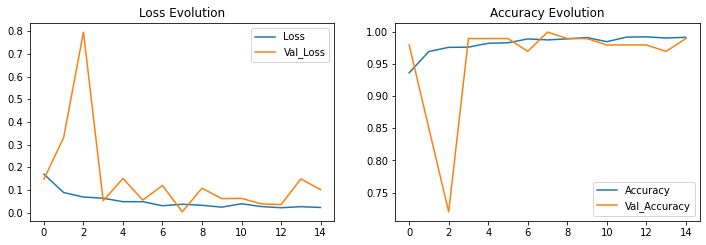

In [55]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [56]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

2790/2790 [==============================] - 89s 32ms/step - loss: 0.3617 - accuracy: 0.8889
Test Accuracy: 88.89%
262/262 [==============================] - 134s 510ms/step - loss: 0.1755 - accuracy: 0.9401
Train Accuracy: 94.01%


In [57]:
from keras.utils.np_utils import to_categorical 
num_classes=len(test.class_indices)

test_labels = test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

# rounded_labels=np.argmax(test, axis=1)

pred = model.predict(test)
# pred = np.argmax(predictions, axis=1)

y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(test_labels, axis=1)


cnf_matrix=confusion_matrix(y_test, y_pred)
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.775819,0.956072,1.000000,0.892115,0.910630,0.910630
recall,0.993548,0.795699,0.887097,0.892115,0.892115,0.892115
f1-score,0.871287,0.868545,0.940171,0.892115,0.893334,0.893334
support,930.000000,930.000000,930.000000,0.892115,2790.000000,2790.000000


In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[924   6   0]
 [190 740   0]
 [ 77  28 825]]


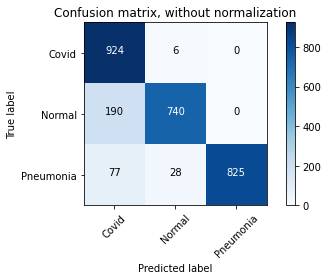

In [60]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Covid', 'Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')